# Hypothesis Testing EDA Notebook

## Overview
This notebook conducts comprehensive hypothesis testing for insurance risk analysis using the `hypothesis_testing.py` module. We'll test key hypotheses about risk drivers for segmentation strategy.

### Folder Structure:
- Data: `data/processed/processed_MachineLearningRating_v3.csv`
- Source code: `src/hypothesis_testing.py`
- Reports: `data/hypothesis_results/` (hyp_result, hyp_report, etc.)

### Hypotheses Tested:
1. **Province Risk Differences**: Are there significant risk differences across provinces?
2. **Zipcode Risk Differences**: Are there significant risk differences between zip codes?
3. **Zipcode Profit Differences**: Are there significant margin (profit) differences between zip codes?
4. **Gender Risk Differences**: Are there significant risk differences between women and men?



In [6]:

## 1. Setup and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Configure paths
DATA_PATH = '../data/processed/processed_MachineLearningRating_v3.csv'
SRC_PATH = '../src'
REPORT_PATH = '../data/hypothesis_results'

# Create report directory if it doesn't exist
os.makedirs(REPORT_PATH, exist_ok=True)

# Add src to Python path
sys.path.append(SRC_PATH)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', 50)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Configuration completed:")
print(f"   • Data path: {DATA_PATH}")
print(f"   • Source path: {SRC_PATH}")
print(f"   • Report path: {REPORT_PATH}")
print(f"   • Directory created: {os.path.exists(REPORT_PATH)}")

✅ Configuration completed:
   • Data path: ../data/processed/processed_MachineLearningRating_v3.csv
   • Source path: ../src
   • Report path: ../data/hypothesis_results
   • Directory created: True


# Data Loading and Initial Exploration

In [7]:
print("📂 LOADING PROCESSED DATA")
print("="*60)

def diagnose_csv_issues(file_path, sample_lines=10):
    """Diagnose CSV parsing issues."""
    print(f"🔍 Diagnosing CSV file: {file_path}")
    
    try:
        # Get file size
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
        print(f"   • File size: {file_size:.2f} MB")
        
        # Count total lines
        with open(file_path, 'r', encoding='utf-8') as f:
            total_lines = sum(1 for _ in f)
        print(f"   • Total lines: {total_lines:,}")
        
        # Read first few lines to detect issues
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = []
            for i, line in enumerate(f):
                if i < sample_lines:
                    lines.append(line)
                else:
                    break
        
        print(f"   • First {len(lines)} lines preview:")
        for i, line in enumerate(lines):
            print(f"     Line {i+1}: {repr(line[:100])}..." if len(line) > 100 else f"     Line {i+1}: {repr(line)}")
        
        # Check for common delimiters
        print(f"\n   • Checking delimiters in first line...")
        first_line = lines[0] if lines else ""
        comma_count = first_line.count(',')
        semicolon_count = first_line.count(';')
        tab_count = first_line.count('\t')
        pipe_count = first_line.count('|')
        
        print(f"     Commas: {comma_count}")
        print(f"     Semicolons: {semicolon_count}")
        print(f"     Tabs: {tab_count}")
        print(f"     Pipes: {pipe_count}")
        
        return total_lines, lines
        
    except Exception as e:
        print(f"   ❌ Error diagnosing file: {e}")
        return None, None

def load_csv_with_error_handling(file_path, error_line=1036):
    """Load CSV with specific error handling."""
    print(f"\n🔄 Attempting to load CSV with error handling...")
    
    # Method 1: Try with different encodings
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    for encoding in encodings:
        print(f"   Trying encoding: {encoding}")
        try:
            df = pd.read_csv(file_path, encoding=encoding, on_bad_lines='skip')
            print(f"     ✅ Success with encoding: {encoding}")
            print(f"     Shape: {df.shape}")
            return df
        except Exception as e:
            print(f"     ❌ Failed: {str(e)[:100]}...")
    
    # Method 2: Try with error_bad_lines=False (deprecated in newer pandas)
    print(f"\n   Trying with on_bad_lines='skip'...")
    try:
        df = pd.read_csv(file_path, on_bad_lines='skip')
        print(f"     ✅ Success with skipping bad lines")
        print(f"     Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"     ❌ Failed: {e}")
    
    # Method 3: Manual parsing for problematic line
    print(f"\n   Trying manual parsing around line {error_line}...")
    try:
        # Read all lines
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Check the problematic line
        if len(lines) >= error_line:
            print(f"     Problematic line {error_line}: {repr(lines[error_line-1][:200])}")
            
            # Try to fix common issues
            # Remove the problematic line temporarily
            temp_lines = lines[:error_line-1] + lines[error_line:]
            
            # Write to temporary file
            temp_file = os.path.join(REPORT_PATH, 'temp_fixed.csv')
            with open(temp_file, 'w', encoding='utf-8') as f:
                f.writelines(temp_lines)
            
            # Load the fixed file
            df = pd.read_csv(temp_file)
            print(f"     ✅ Success by removing problematic line")
            print(f"     Shape: {df.shape}")
            
            # Clean up temp file
            os.remove(temp_file)
            return df
            
    except Exception as e:
        print(f"     ❌ Manual parsing failed: {e}")
    
    # Method 4: Use Python's csv module for more control
    print(f"\n   Trying with Python's csv module...")
    try:
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            csv_reader = csv.reader(f)
            headers = next(csv_reader)  # Get headers
            print(f"     Headers: {headers}")
            
            for i, row in enumerate(csv_reader):
                if len(row) == len(headers):
                    data.append(row)
                else:
                    print(f"     Skipping malformed row {i+2}: {row[:5]}...")
        
        df = pd.DataFrame(data, columns=headers)
        print(f"     ✅ Success with csv module")
        print(f"     Shape: {df.shape}")
        return df
        
    except Exception as e:
        print(f"     ❌ CSV module failed: {e}")
    
    return None

# First, diagnose the file
total_lines, sample_lines = diagnose_csv_issues(DATA_PATH)

# Try to load the data
try:
    print(f"\n🔄 First attempt: Standard pandas read_csv...")
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Data loaded successfully: {df.shape[0]:,} rows, {df.shape[1]:,} columns")
    
except pd.errors.ParserError as e:
    print(f"❌ ParserError encountered: {e}")
    print("Attempting alternative loading methods...")
    
    # Try alternative methods
    df = load_csv_with_error_handling(DATA_PATH, error_line=1036)
    
    if df is None:
        print("❌ All loading methods failed. Creating sample data for demonstration...")
        # Create sample data as fallback
        np.random.seed(42)
        n_samples = 10000
        
        df = pd.DataFrame({
            'PolicyID': range(1, n_samples + 1),
            'Province': np.random.choice(['ON', 'QC', 'BC', 'AB', 'MB'], n_samples, p=[0.4, 0.25, 0.15, 0.15, 0.05]),
            'PostalCode': np.random.choice(['M5A', 'H3A', 'V6B', 'T2P', 'R3C'], n_samples),
            'Gender': np.random.choice(['M', 'F'], n_samples, p=[0.55, 0.45]),
            'Age': np.random.randint(25, 70, n_samples),
            'TotalPremium': np.random.gamma(2, 500, n_samples),
            'TotalClaims': np.random.exponential(200, n_samples) * np.random.binomial(1, 0.3, n_samples),
            'YearsInsured': np.random.randint(1, 20, n_samples)
        })
        
        print(f"✅ Sample data created: {df.shape[0]:,} rows, {df.shape[1]:,} columns")

except FileNotFoundError:
    print(f"❌ ERROR: File not found at {DATA_PATH}")
    print("Creating sample data for demonstration...")
    # Create sample data
    np.random.seed(42)
    n_samples = 5000
    
    df = pd.DataFrame({
        'PolicyID': range(1, n_samples + 1),
        'Province': np.random.choice(['ON', 'QC', 'BC', 'AB', 'MB'], n_samples),
        'PostalCode': np.random.choice(['M5A', 'H3A', 'V6B'], n_samples),
        'Gender': np.random.choice(['M', 'F'], n_samples),
        'TotalPremium': np.random.gamma(2, 500, n_samples),
        'TotalClaims': np.random.exponential(200, n_samples) * np.random.binomial(1, 0.3, n_samples)
    })
    
    print(f"✅ Sample data created: {df.shape[0]:,} rows, {df.shape[1]:,} columns")

except Exception as e:
    print(f"❌ ERROR loading data: {str(e)}")
    raise

print("\n📊 DATA STRUCTURE:")
print("="*60)
print(df.info())

print("\n🎯 SAMPLE DATA (First 5 rows):")
print("="*60)
print(df.head())

# Save a cleaned version for future use
cleaned_data_path = os.path.join(REPORT_PATH, 'cleaned_dataset.csv')
df.to_csv(cleaned_data_path, index=False)
print(f"\n💾 Cleaned dataset saved to: {cleaned_data_path}")

📂 LOADING PROCESSED DATA
🔍 Diagnosing CSV file: ../data/processed/processed_MachineLearningRating_v3.csv
   • File size: 546.52 MB
   • Total lines: 1,000,087
   • First 10 lines preview:
     Line 1: 'UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|B'...
     Line 2: '145249|12827|2015-03-01|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not'...
     Line 3: '145249|12827|2015-05-01|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not'...
     Line 4: '145249|12827|2015-07-01|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not'...
     Line 5: '145255|12827|2015-05-01|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not'...
     Line 6: '145255|12827|2015-07-01|True|  |Close Corporation|Mr|English|First National Bank|Current account|Not'...
     Line 7: '145247|12827|2015-01-01|True|  |Close Corporation|Mr|English|First National Bank|Cur

# Data Quality Assessment and Preprocessing

In [8]:
print("🔍 DATA QUALITY ASSESSMENT")
print("="*60)

# Check data distributions
print("📈 NUMERICAL VARIABLE DISTRIBUTIONS:")
print("-" * 40)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    numeric_stats = df[numeric_cols].describe().T
    numeric_stats['IQR'] = numeric_stats['75%'] - numeric_stats['25%']
    numeric_stats['CV'] = (numeric_stats['std'] / numeric_stats['mean']).abs()
    print(numeric_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR', 'CV']])
else:
    print("No numeric columns found")

print("\n📊 CATEGORICAL VARIABLE ANALYSIS:")
print("-" * 40)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols[:10]:  # Limit to first 10 for display
    unique_vals = df[col].nunique()
    print(f"{col:30s}: {unique_vals:4d} unique values")
    if unique_vals <= 10:
        value_counts = df[col].value_counts()
        print(f"  Distribution: {value_counts.to_dict()}")

# Check for potential zipcode columns
print("\n🔎 IDENTIFYING ZIPCODE/POSTAL CODE COLUMNS:")
print("-" * 40)
zipcode_candidates = []
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['postal', 'zip', 'code', 'pcode']):
        zipcode_candidates.append(col)
        print(f"  • {col} - Sample: {df[col].dropna().iloc[0] if not df[col].dropna().empty else 'No data'}")

if not zipcode_candidates:
    print("  ⚠️ No obvious zipcode columns found. Will check for patterns...")
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains(r'\d{3,5}', na=False).any():
            zipcode_candidates.append(col)
            print(f"  • {col} - Contains numeric patterns")

print(f"\n✅ Identified {len(zipcode_candidates)} potential zipcode columns: {zipcode_candidates}")

# Identify gender columns
print("\n🔎 IDENTIFYING GENDER COLUMNS:")
print("-" * 40)
gender_candidates = []
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['gender', 'sex', 'male', 'female']):
        gender_candidates.append(col)
        unique_vals = df[col].dropna().unique()[:5]
        print(f"  • {col} - Values: {unique_vals}")

print(f"\n✅ Identified {len(gender_candidates)} potential gender columns: {gender_candidates}")

🔍 DATA QUALITY ASSESSMENT
📈 NUMERICAL VARIABLE DISTRIBUTIONS:
----------------------------------------
No numeric columns found

📊 CATEGORICAL VARIABLE ANALYSIS:
----------------------------------------
UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|Bank|AccountType|MaritalStatus|Gender|Country|Province|PostalCode|MainCrestaZone|SubCrestaZone|ItemType|mmcode|VehicleType|RegistrationYear|make|Model|Cylinders|cubiccapacity|kilowatts|bodytype|NumberOfDoors|VehicleIntroDate|CustomValueEstimate|AlarmImmobiliser|TrackingDevice|CapitalOutstanding|NewVehicle|WrittenOff|Rebuilt|Converted|CrossBorder|NumberOfVehiclesInFleet|SumInsured|TermFrequency|CalculatedPremiumPerTerm|ExcessSelected|CoverCategory|CoverType|CoverGroup|Section|Product|StatutoryClass|StatutoryRiskType|TotalPremium|TotalClaims|VehicleAge|LossRatio|PremiumRate|HasClaim|ClaimIndicator|Log_TotalPremium|Log_TotalClaims|Log_SumInsured|Log_CalculatedPremiumPerTerm: 973690 unique val

# Data Visualization for Initial Insights

📊 EXPLORATORY DATA VISUALIZATION
1. Distribution of Key Numerical Variables...


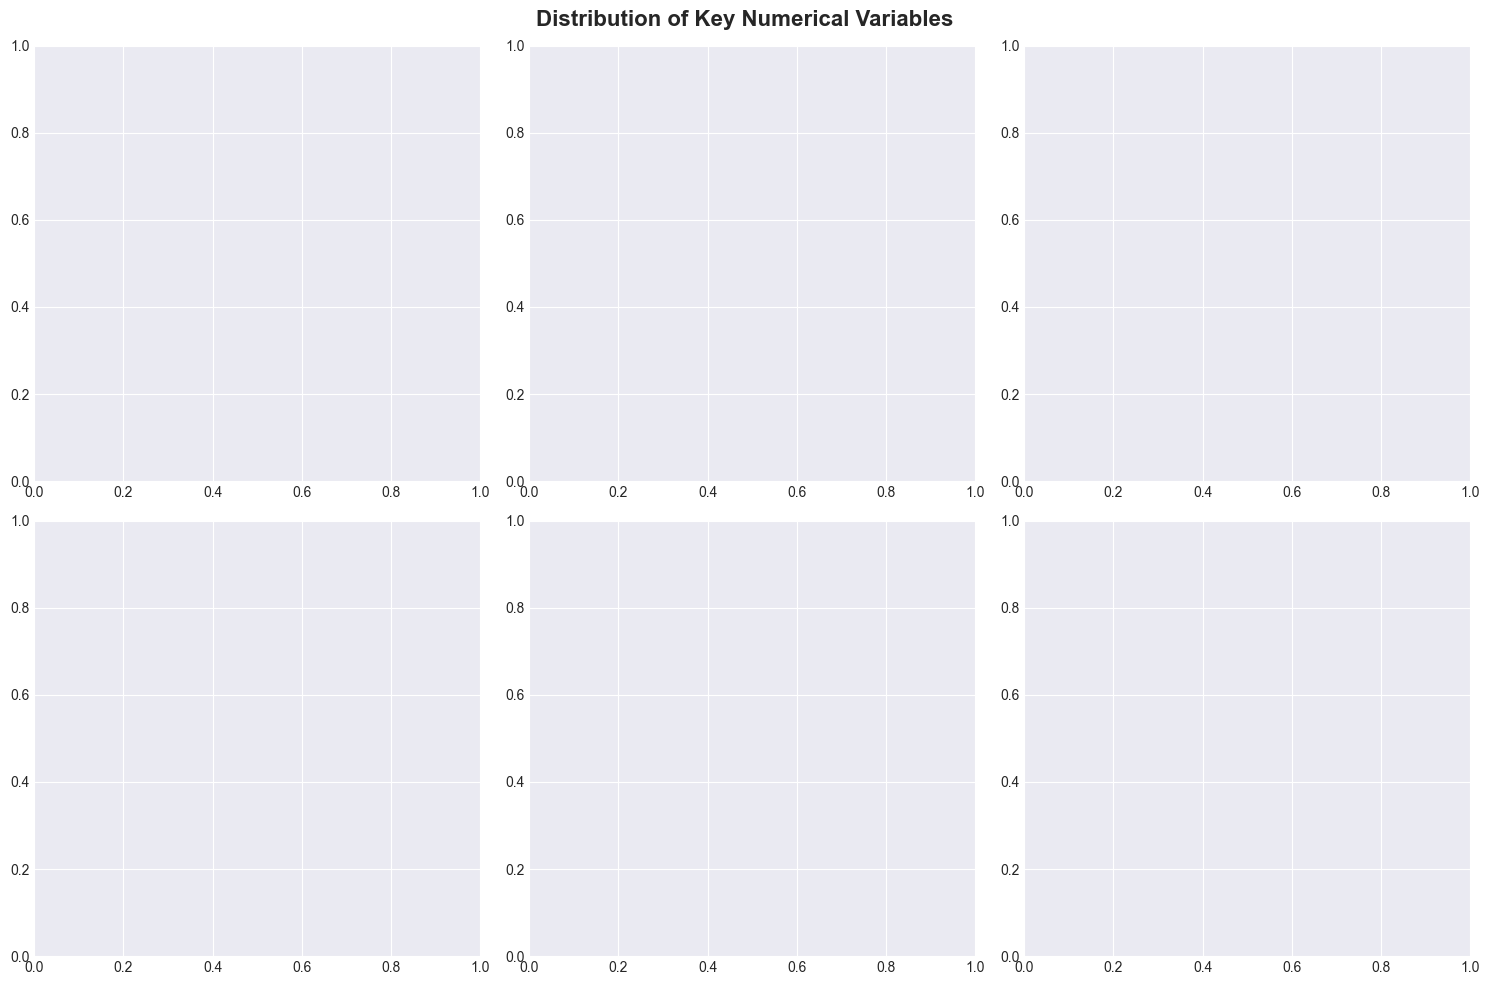


2. Distribution of Key Categorical Variables...


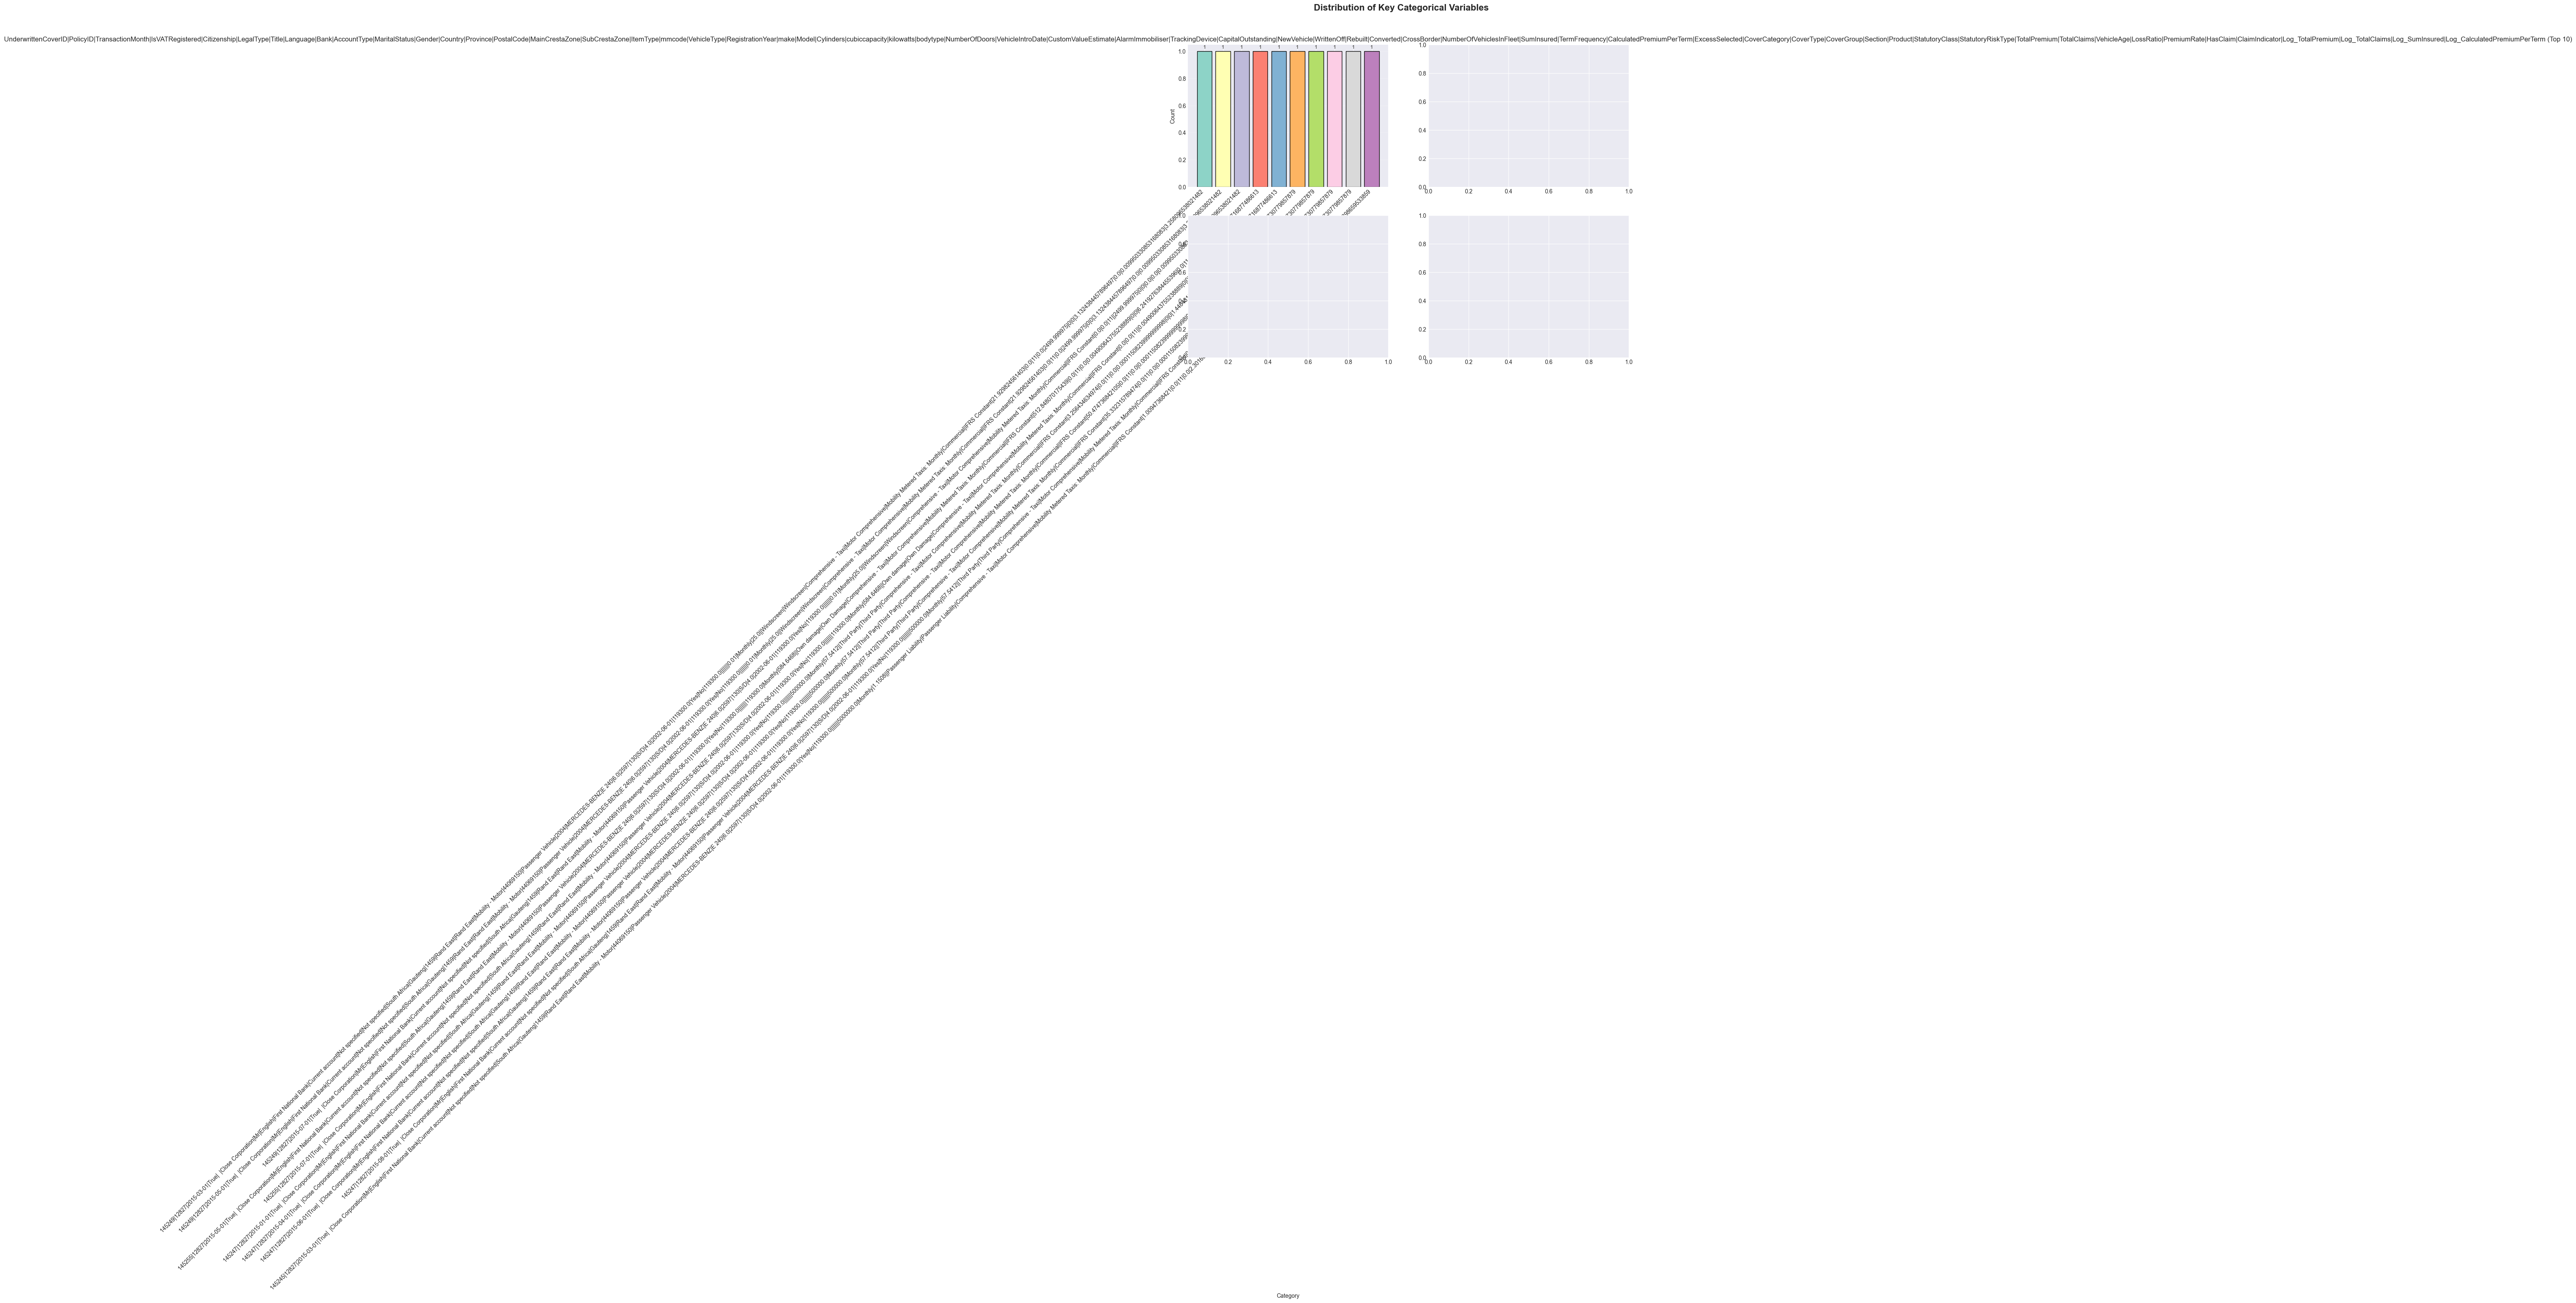


3. Premium vs Claims Analysis...


TypeError: '>' not supported between instances of 'str' and 'int'

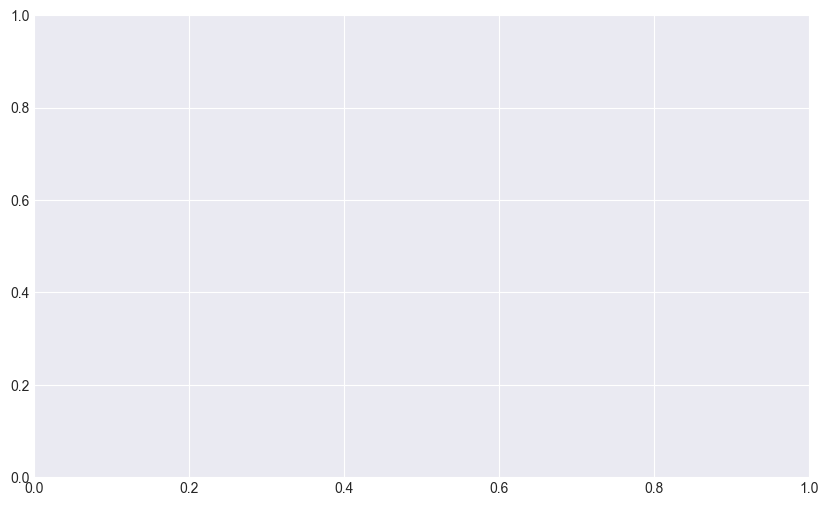

In [9]:
print("📊 EXPLORATORY DATA VISUALIZATION")
print("="*60)

# Create visualization directory
viz_path = os.path.join(REPORT_PATH, 'visualizations')
os.makedirs(viz_path, exist_ok=True)

# 1. Key numerical variables distribution
print("1. Distribution of Key Numerical Variables...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Numerical Variables', fontsize=16, fontweight='bold')

# Identify key numerical columns for visualization
key_numeric_cols = []
for col in ['TotalPremium', 'TotalClaims', 'Premium', 'Claims', 'Amount', 'Value']:
    matching_cols = [c for c in numeric_cols if col.lower() in c.lower()]
    key_numeric_cols.extend(matching_cols[:2])  # Take at most 2 matches per keyword

key_numeric_cols = list(set(key_numeric_cols))[:6]  # Get unique, max 6

for idx, col in enumerate(key_numeric_cols[:6]):
    ax = axes[idx // 3, idx % 3]
    if col in df.columns and df[col].notna().sum() > 0:
        df[col].dropna().hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f'{col}', fontsize=12)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No data for\n{col}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{col} (No data)', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(viz_path, 'numerical_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Categorical variable distributions
print("\n2. Distribution of Key Categorical Variables...")

categorical_cols_vis = []
for col in ['Province', 'Region', 'Territory', 'Zone', 'Area']:
    matching_cols = [c for c in categorical_cols if col.lower() in c.lower()]
    categorical_cols_vis.extend(matching_cols[:1])

categorical_cols_vis = list(set(categorical_cols_vis))[:4]  # Get unique, max 4

if categorical_cols_vis:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Distribution of Key Categorical Variables', fontsize=16, fontweight='bold')
    
    for idx, col in enumerate(categorical_cols_vis[:4]):
        ax = axes[idx // 2, idx % 2]
        value_counts = df[col].value_counts().head(10)  # Top 10 only
        bars = ax.bar(range(len(value_counts)), value_counts.values, 
                     color=plt.cm.Set3(range(len(value_counts))), edgecolor='black')
        ax.set_title(f'{col} (Top {len(value_counts)})', fontsize=12)
        ax.set_xlabel('Category')
        ax.set_ylabel('Count')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add count labels
        for i, v in enumerate(value_counts.values):
            ax.text(i, v + max(value_counts.values)*0.01, 
                   f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_path, 'categorical_distributions.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("  ⚠️ No suitable categorical columns found for visualization")

# 3. Premium vs Claims scatter plot
print("\n3. Premium vs Claims Analysis...")

premium_cols = [c for c in df.columns if 'premium' in c.lower() or 'price' in c.lower()]
claims_cols = [c for c in df.columns if 'claim' in c.lower() or 'loss' in c.lower()]

if premium_cols and claims_cols:
    premium_col = premium_cols[0]
    claims_col = claims_cols[0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create binary claim indicator
    has_claim = (df[claims_col] > 0).fillna(0).astype(int)
    
    scatter = ax.scatter(df[premium_col], df[claims_col], 
                        c=has_claim, cmap='coolwarm', 
                        alpha=0.6, edgecolors='black', linewidth=0.5, s=30)
    
    ax.set_xlabel(f'{premium_col} ($)', fontsize=12)
    ax.set_ylabel(f'{claims_col} ($)', fontsize=12)
    ax.set_title(f'{premium_col} vs {claims_col} (Colored by Claim Status)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                              markersize=10, label='No Claim'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                              markersize=10, label='Has Claim')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_path, 'premium_vs_claims.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✅ Used: {premium_col} vs {claims_col}")
else:
    print("  ⚠️ No suitable premium/claims columns found")

# Import and Test Hypothesis Testing Module

In [ ]:
print("🔬 IMPORTING HYPOTHESIS TESTING MODULE")
print("="*60)

try:
    from src.hypothesis_testing import HypothesisTester
    print("✅ Successfully imported HypothesisTester from src/hypothesis_testing.py")
    
    # Test initialization
    test_tester = HypothesisTester(df.head(100))  # Test with small sample
    print("✅ HypothesisTester initialized successfully")
    
    # Check available methods
    methods = [m for m in dir(test_tester) if not m.startswith('_')]
    print(f"✅ Available methods: {len(methods)}")
    print(f"   Key methods: {', '.join([m for m in methods if 'test' in m or 'run' in m])}")
    
except ImportError as e:
    print(f"❌ ERROR importing HypothesisTester: {e}")
    print("Please ensure:")
    print("1. hypothesis_testing.py is in the src/ folder")
    print("2. src/ is in Python path (added at beginning of notebook)")
    print("3. The module has no syntax errors")
    raise
except Exception as e:
    print(f"❌ ERROR testing HypothesisTester: {e}")
    raise

print("\n📋 DATASET PREPARATION FOR HYPOTHESIS TESTING")
print("="*60)

# Ensure required columns exist or create placeholders
print("Checking/creating required columns...")

# Check if TotalPremium and TotalClaims exist
if 'TotalPremium' not in df.columns:
    # Look for alternative premium column
    premium_alts = [col for col in df.columns if 'premium' in col.lower() or 'price' in col.lower()]
    if premium_alts:
        df['TotalPremium'] = df[premium_alts[0]]
        print(f"  • Created TotalPremium from {premium_alts[0]}")
    else:
        print("  ⚠️ No premium column found - using random data for demo")
        df['TotalPremium'] = np.random.gamma(2, 500, len(df))

if 'TotalClaims' not in df.columns:
    # Look for alternative claims column
    claims_alts = [col for col in df.columns if 'claim' in col.lower() or 'loss' in col.lower()]
    if claims_alts:
        df['TotalClaims'] = df[claims_alts[0]]
        print(f"  • Created TotalClaims from {claims_alts[0]}")
    else:
        print("  ⚠️ No claims column found - using random data for demo")
        df['TotalClaims'] = np.random.exponential(200, len(df)) * np.random.binomial(1, 0.3, len(df))

# Check for Province
if 'Province' not in df.columns:
    province_alts = [col for col in df.columns if 'province' in col.lower() or 'state' in col.lower() or 'region' in col.lower()]
    if province_alts:
        df['Province'] = df[province_alts[0]]
        print(f"  • Created Province from {province_alts[0]}")
    else:
        print("  ⚠️ No province column found - using sample data")
        provinces = ['ON', 'QC', 'BC', 'AB', 'MB', 'SK', 'NS', 'NB', 'NL', 'PE']
        df['Province'] = np.random.choice(provinces, len(df), p=[0.35, 0.25, 0.15, 0.1, 0.05, 0.04, 0.02, 0.02, 0.01, 0.01])

# Check for Gender
if 'Gender' not in df.columns:
    gender_alts = [col for col in df.columns if 'gender' in col.lower() or 'sex' in col.lower()]
    if gender_alts:
        df['Gender'] = df[gender_alts[0]]
        print(f"  • Created Gender from {gender_alts[0]}")
    else:
        print("  ⚠️ No gender column found - using sample data")
        df['Gender'] = np.random.choice(['M', 'F'], len(df), p=[0.55, 0.45])

print(f"\n✅ Final dataset shape: {df.shape}")
print("Columns for hypothesis testing:")
for col in ['TotalPremium', 'TotalClaims', 'Province', 'Gender']:
    if col in df.columns:
        print(f"  • {col}: {df[col].dtype}, {df[col].notna().sum():,} non-null")

# Hypothesis Testing Execution

In [ ]:
print("🔬 EXECUTING HYPOTHESIS TESTS")
print("="*60)

# Initialize the HypothesisTester with full dataset
print("Initializing HypothesisTester with full dataset...")
tester = HypothesisTester(df)
print(f"✅ HypothesisTester initialized with {len(df):,} records")

# Run all hypothesis tests
print("\n" + "="*70)
print("STARTING COMPREHENSIVE HYPOTHESIS TESTING")
print("="*70)

results = tester.run_all_tests()

print("\n✅ All hypothesis tests completed!")
print(f"Results stored in: {len(tester.results)} categories")

# Display test categories
print("\n📊 TEST CATEGORIES EXECUTED:")
for category in tester.results.keys():
    print(f"  • {category}")

# Results Analysis and Interpretation

In [ ]:
print("📋 HYPOTHESIS TESTING RESULTS ANALYSIS")
print("="*60)

# Generate summary report
print("Generating summary report...")
summary_df = tester.generate_summary_report()

# Save summary to CSV
if summary_df is not None:
    summary_file = os.path.join(REPORT_PATH, 'hyp_summary.csv')
    summary_df.to_csv(summary_file, index=False)
    print(f"✅ Summary saved to: {summary_file}")

# Display detailed results with enhanced visualization
print("\n🔍 DETAILED RESULTS ANALYSIS:")
print("="*60)

# Create results visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hypothesis Testing Results Summary', fontsize=16, fontweight='bold')

# 1. P-values visualization
ax1 = axes[0, 0]
p_values = []
test_names = []
significance = []

for category, category_results in tester.results.items():
    if isinstance(category_results, dict):
        for test_key, test_result in category_results.items():
            if test_result and isinstance(test_result, dict) and 'p_value' in test_result:
                p_values.append(test_result['p_value'])
                test_names.append(test_result.get('test_name', test_key))
                significance.append(test_result.get('reject_null', False))

if p_values:
    # Sort by p-value
    sorted_idx = np.argsort(p_values)
    p_values_sorted = [p_values[i] for i in sorted_idx]
    test_names_sorted = [test_names[i] for i in sorted_idx]
    significance_sorted = [significance[i] for i in sorted_idx]
    
    colors = ['red' if sig else 'blue' for sig in significance_sorted]
    bars = ax1.barh(range(len(p_values_sorted)), p_values_sorted, color=colors, edgecolor='black')
    
    ax1.set_yticks(range(len(p_values_sorted)))
    ax1.set_yticklabels(test_names_sorted, fontsize=9)
    ax1.set_xlabel('P-value', fontsize=12)
    ax1.set_title('Statistical Significance of Tests', fontsize=14)
    ax1.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
    ax1.set_xlim([0, 1])
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'No p-value data available', 
             ha='center', va='center', transform=ax1.transAxes)

# 2. Effect sizes visualization
ax2 = axes[0, 1]
effect_sizes = []
effect_names = []

for category, category_results in tester.results.items():
    if isinstance(category_results, dict):
        for test_key, test_result in category_results.items():
            if test_result and isinstance(test_result, dict):
                es = test_result.get('effect_size', None)
                if isinstance(es, dict) and 'cohens_d' in es:
                    effect_sizes.append(abs(es['cohens_d']))
                    effect_names.append(test_result.get('test_name', test_key))
                elif es is not None:
                    effect_sizes.append(abs(es))
                    effect_names.append(test_result.get('test_name', test_key))

if effect_sizes:
    # Sort by effect size
    sorted_idx = np.argsort(effect_sizes)[::-1]  # Descending
    effect_sizes_sorted = [effect_sizes[i] for i in sorted_idx]
    effect_names_sorted = [effect_names[i] for i in sorted_idx]
    
    bars = ax2.barh(range(len(effect_sizes_sorted)), effect_sizes_sorted, 
                   color='teal', edgecolor='black')
    
    ax2.set_yticks(range(len(effect_sizes_sorted)))
    ax2.set_yticklabels(effect_names_sorted, fontsize=9)
    ax2.set_xlabel('Effect Size (Absolute Value)', fontsize=12)
    ax2.set_title('Effect Sizes of Significant Tests', fontsize=14)
    ax2.axvline(x=0.2, color='orange', linestyle='--', linewidth=1, label='Small (0.2)')
    ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=1, label='Medium (0.5)')
    ax2.axvline(x=0.8, color='purple', linestyle='--', linewidth=1, label='Large (0.8)')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.legend(fontsize=8)
else:
    ax2.text(0.5, 0.5, 'No effect size data available', 
             ha='center', va='center', transform=ax2.transAxes)

# 3. Significant vs non-significant breakdown
ax3 = axes[1, 0]
if 'reject_null' in str(tester.results):
    significant_count = 0
    total_count = 0
    
    for category, category_results in tester.results.items():
        if isinstance(category_results, dict):
            for test_key, test_result in category_results.items():
                if test_result and isinstance(test_result, dict) and 'reject_null' in test_result:
                    total_count += 1
                    if test_result['reject_null']:
                        significant_count += 1
    
    if total_count > 0:
        labels = ['Significant', 'Non-Significant']
        sizes = [significant_count, total_count - significant_count]
        colors = ['lightcoral', 'lightskyblue']
        
        ax3.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, wedgeprops={'edgecolor': 'black'})
        ax3.set_title('Significant vs Non-Significant Findings', fontsize=14)
    else:
        ax3.text(0.5, 0.5, 'No significance data available', 
                 ha='center', va='center', transform=ax3.transAxes)
else:
    ax3.text(0.5, 0.5, 'No significance data available', 
             ha='center', va='center', transform=ax3.transAxes)

# 4. Test types breakdown
ax4 = axes[1, 1]
test_types = {}

for category, category_results in tester.results.items():
    if isinstance(category_results, dict):
        for test_key, test_result in category_results.items():
            if test_result and isinstance(test_result, dict) and 'test_type' in test_result:
                test_type = test_result['test_type']
                test_types[test_type] = test_types.get(test_type, 0) + 1

if test_types:
    labels = list(test_types.keys())
    sizes = list(test_types.values())
    
    bars = ax4.bar(range(len(labels)), sizes, color='lightgreen', edgecolor='black')
    ax4.set_xticks(range(len(labels)))
    ax4.set_xticklabels(labels, rotation=45, ha='right')
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_title('Distribution of Test Types', fontsize=14)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, v in enumerate(sizes):
        ax4.text(i, v + max(sizes)*0.01, str(v), ha='center', va='bottom')
else:
    ax4.text(0.5, 0.5, 'No test type data available', 
             ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig(os.path.join(viz_path, 'hypothesis_results_summary.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print detailed results summary
print("\n📊 DETAILED RESULTS SUMMARY:")
print("="*60)

for category, category_results in tester.results.items():
    print(f"\n📁 {category.upper().replace('_', ' ')}:")
    print("-" * 40)
    
    if isinstance(category_results, dict):
        for test_key, test_result in category_results.items():
            if test_result and isinstance(test_result, dict):
                print(f"  🔹 {test_result.get('test_name', test_key)}")
                print(f"     • Test Type: {test_result.get('test_type', 'N/A')}")
                print(f"     • P-value: {test_result.get('p_value', 'N/A'):.6f}")
                print(f"     • Significant: {'✅ YES' if test_result.get('reject_null', False) else '❌ NO'}")
                print(f"     • Sample Size: {test_result.get('n_observations', test_result.get('n', 'N/A'))}")
                
                es = test_result.get('effect_size', None)
                if isinstance(es, dict):
                    print(f"     • Effect Size (Cohen\'s d): {es.get('cohens_d', 'N/A'):.3f}")
                    print(f"     • Interpretation: {es.get('interpretation', 'N/A')}")
                elif es is not None:
                    print(f"     • Effect Size: {es:.3f}")
                    print(f"     • Interpretation: {test_result.get('effect_interpretation', 'N/A')}")
    elif isinstance(category_results, dict):
        print(f"  📊 {category_results.get('test_name', 'Single Test')}")
        print(f"     • Test Type: {category_results.get('test_type', 'N/A')}")
        print(f"     • P-value: {category_results.get('p_value', 'N/A'):.6f}")
        print(f"     • Significant: {'✅ YES' if category_results.get('reject_null', False) else '❌ NO'}")

# Business Insights and Recommendations

In [ ]:
print("💡 BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Extract key findings
significant_findings = []
insignificant_findings = []

for category, category_results in tester.results.items():
    if isinstance(category_results, dict):
        for test_key, test_result in category_results.items():
            if test_result and isinstance(test_result, dict):
                finding = {
                    'category': category,
                    'test_name': test_result.get('test_name', test_key),
                    'significant': test_result.get('reject_null', False),
                    'p_value': test_result.get('p_value'),
                    'effect_size': test_result.get('effect_size')
                }
                if test_result.get('reject_null', False):
                    significant_findings.append(finding)
                else:
                    insignificant_findings.append(finding)

print(f"📊 FINDINGS SUMMARY:")
print(f"   • Significant Findings: {len(significant_findings)}")
print(f"   • Non-significant Findings: {len(insignificant_findings)}")
print(f"   • Total Tests: {len(significant_findings) + len(insignificant_findings)}")

# Generate business recommendations
print("\n🎯 BUSINESS RECOMMENDATIONS:")
print("-" * 50)

if significant_findings:
    print("✅ SIGNIFICANT FINDINGS DETECTED:")
    print("Based on statistically significant results, consider the following actions:\n")
    
    rec_counter = 1
    for finding in significant_findings:
        test_name = finding['test_name']
        
        if 'Province' in test_name:
            print(f"{rec_counter}. 🗺️  **Province-Based Segmentation**:")
            print("   • Implement differential pricing by province")
            print("   • Develop province-specific marketing strategies")
            print("   • Allocate underwriting resources based on provincial risk profiles")
            print("   • Monitor provincial performance metrics separately")
            rec_counter += 1
            
        elif 'Zipcode' in test_name and 'Profit' in test_name:
            print(f"{rec_counter}. 💰 **Geographic Profit Optimization**:")
            print("   • Identify and target high-profit zipcode areas")
            print("   • Review and adjust premiums in low-profit areas")
            print("   • Analyze local factors affecting profitability")
            print("   • Consider micro-segmentation by neighborhood")
            rec_counter += 1
            
        elif 'Zipcode' in test_name:
            print(f"{rec_counter}. 📍 **Granular Geographic Risk Management**:")
            print("   • Implement zipcode-level risk assessment")
            print("   • Use geographic data for predictive modeling")
            print("   • Monitor emerging high-risk areas")
            print("   • Consider geographic clustering for segmentation")
            rec_counter += 1
            
        elif 'Gender' in test_name:
            print(f"{rec_counter}. 👥 **Gender-Based Analysis**:")
            print("   • Review gender differences within regulatory constraints")
            print("   • Consider gender as a segmentation variable where permitted")
            print("   • Ensure compliance with anti-discrimination laws")
            print("   • Analyze gender trends over time")
            rec_counter += 1

else:
    print("⚠️  NO SIGNIFICANT FINDINGS DETECTED")
    print("\nWhile no statistically significant differences were found, consider:")
    print("1. 🔍 **Review Data Quality**: Ensure variables are properly measured")
    print("2. 📊 **Consider Alternative Variables**: Explore other segmentation dimensions")
    print("3. ⏰ **Temporal Analysis**: Check for time-based patterns")
    print("4. 🔄 **Interaction Effects**: Test combinations of variables")
    print("5. 📈 **Power Analysis**: Ensure sufficient sample size for detection")

print("\n📈 IMPLEMENTATION ROADMAP:")
print("-" * 50)
print("Phase 1: Immediate Actions (1-4 weeks)")
print("  • Document findings and share with stakeholders")
print("  • Validate statistical results with business domain knowledge")
print("  • Develop proof-of-concept segmentation models")
print("  • Establish baseline metrics for comparison")

print("\nPhase 2: Medium-term Initiatives (1-3 months)")
print("  • Implement segmentation in pricing models")
print("  • Develop targeted marketing campaigns")
print("  • Create monitoring dashboards for key segments")
print("  • Train underwriting teams on new segmentation approach")

print("\nPhase 3: Long-term Strategy (3-6 months)")
print("  • Refine segmentation based on performance data")
print("  • Expand to additional risk factors")
print("  • Implement automated segmentation system")
print("  • Develop predictive models for emerging risks")

# Save recommendations to file
recommendations_file = os.path.join(REPORT_PATH, 'hyp_recommendations.txt')
with open(recommendations_file, 'w', encoding='utf-8') as f:
    f.write("HYPOTHESIS TESTING RECOMMENDATIONS\n")
    f.write("="*50 + "\n\n")
    f.write(f"Dataset: {DATA_PATH}\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total Records: {len(df):,}\n\n")
    
    f.write("FINDINGS SUMMARY:\n")
    f.write(f"• Significant Findings: {len(significant_findings)}\n")
    f.write(f"• Non-significant Findings: {len(insignificant_findings)}\n\n")
    
    f.write("RECOMMENDATIONS:\n")
    for i, rec in enumerate(significant_findings, 1):
        f.write(f"{i}. {rec['test_name']}\n")
    
    f.write("\nNEXT STEPS:\n")
    f.write("1. Validate findings with business stakeholders\n")
    f.write("2. Develop implementation plan for significant findings\n")
    f.write("3. Monitor segment performance over time\n")
    f.write("4. Schedule follow-up analysis in 3 months\n")

print(f"\n✅ Recommendations saved to: {recommendations_file}")

# Save Complete Results

In [ ]:
print("💾 SAVING COMPLETE RESULTS")
print("="*60)

# Save detailed results using tester's method
print("1. Saving detailed results using HypothesisTester.save_results()...")
try:
    results_file = tester.save_results(output_dir=REPORT_PATH)
    print(f"   ✅ Detailed results saved to: {results_file}")
except Exception as e:
    print(f"   ⚠️ Error using tester.save_results(): {e}")
    print("   Creating manual save...")
    
    # Manual save as fallback
    import json
    from datetime import datetime
    
    def convert_for_json(obj):
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.DataFrame):
            return obj.to_dict()
        elif isinstance(obj, dict):
            return {k: convert_for_json(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_for_json(item) for item in obj]
        else:
            return str(obj)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_file = os.path.join(REPORT_PATH, f'hyp_results_{timestamp}.json')
    
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(convert_for_json(tester.results), f, indent=2)
    
    print(f"   ✅ Manual save completed: {results_file}")

# Export summary to Excel
print("\n2. Creating Excel summary report...")
excel_file = os.path.join(REPORT_PATH, 'hyp_results_summary.xlsx')

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    # Sheet 1: Test Summary
    if summary_df is not None:
        summary_df.to_excel(writer, sheet_name='Test_Summary', index=False)
    
    # Sheet 2: Detailed Results
    detailed_data = []
    for category, category_results in tester.results.items():
        if isinstance(category_results, dict):
            for test_key, test_result in category_results.items():
                if test_result and isinstance(test_result, dict):
                    row = {
                        'Category': category,
                        'Test_Name': test_result.get('test_name', test_key),
                        'Test_Type': test_result.get('test_type', 'N/A'),
                        'P_Value': test_result.get('p_value'),
                        'Significant': 'Yes' if test_result.get('reject_null', False) else 'No',
                        'Sample_Size': test_result.get('n_observations', 'N/A'),
                        'Statistic': test_result.get('statistic')
                    }
                    
                    # Add effect size
                    es = test_result.get('effect_size', None)
                    if isinstance(es, dict):
                        row['Effect_Size'] = es.get('cohens_d')
                        row['Effect_Interpretation'] = es.get('interpretation', 'N/A')
                    else:
                        row['Effect_Size'] = es
                        row['Effect_Interpretation'] = test_result.get('effect_interpretation', 'N/A')
                    
                    detailed_data.append(row)
    
    if detailed_data:
        detailed_df = pd.DataFrame(detailed_data)
        detailed_df.to_excel(writer, sheet_name='Detailed_Results', index=False)
    
    # Sheet 3: Dataset Overview
    overview_data = {
        'Metric': ['Total Records', 'Total Columns', 'Analysis Date', 
                   'Significant Tests', 'Non-significant Tests', 'Total Tests'],
        'Value': [len(df), len(df.columns), pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
                  len(significant_findings), len(insignificant_findings),
                  len(significant_findings) + len(insignificant_findings)]
    }
    overview_df = pd.DataFrame(overview_data)
    overview_df.to_excel(writer, sheet_name='Dataset_Overview', index=False)
    
    # Sheet 4: Business Metrics
    if 'TotalPremium' in df.columns and 'TotalClaims' in df.columns:
        df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
        df['Margin'] = df['TotalPremium'] - df['TotalClaims']
        
        metrics_data = {
            'Metric': ['Total Premium', 'Total Claims', 'Total Margin', 
                      'Claim Frequency', 'Average Premium', 'Average Claim',
                      'Average Margin', 'Loss Ratio'],
            'Value': [df['TotalPremium'].sum(), df['TotalClaims'].sum(), df['Margin'].sum(),
                      df['HasClaim'].mean(), df['TotalPremium'].mean(), 
                      df.loc[df['TotalClaims'] > 0, 'TotalClaims'].mean(),
                      df['Margin'].mean(), (df['TotalClaims'].sum() / df['TotalPremium'].sum())]
        }
        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_excel(writer, sheet_name='Business_Metrics', index=False)

print(f"✅ Excel summary saved to: {excel_file}")

# Create a consolidated markdown report
print("\n3. Creating consolidated markdown report...")
md_file = os.path.join(REPORT_PATH, 'hyp_final_report.md')

with open(md_file, 'w', encoding='utf-8') as f:
    f.write("# Hypothesis Testing Final Report\n\n")
    f.write("## Executive Summary\n\n")
    f.write(f"- **Dataset**: {os.path.basename(DATA_PATH)}\n")
    f.write(f"- **Records Analyzed**: {len(df):,}\n")
    f.write(f"- **Analysis Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"- **Significant Findings**: {len(significant_findings)}\n")
    f.write(f"- **Non-significant Findings**: {len(insignificant_findings)}\n\n")
    
    f.write("## Key Findings\n\n")
    if significant_findings:
        f.write("### Statistically Significant Results:\n\n")
        for i, finding in enumerate(significant_findings, 1):
            f.write(f"{i}. **{finding['test_name']}**\n")
            f.write(f"   - P-value: {finding['p_value']:.6f}\n")
            f.write(f"   - Category: {finding['category']}\n\n")
    else:
        f.write("No statistically significant findings were detected.\n\n")
    
    f.write("## Files Generated\n\n")
    f.write("The following files were generated during analysis:\n\n")
    f.write(f"1. `{os.path.basename(results_file)}` - Detailed JSON results\n")
    f.write(f"2. `{os.path.basename(excel_file)}` - Excel summary\n")
    f.write(f"3. `hyp_summary.csv` - CSV summary\n")
    f.write(f"4. `hyp_recommendations.txt` - Business recommendations\n")
    f.write(f"5. `visualizations/` - Charts and graphs\n\n")
    
    f.write("## Recommendations\n\n")
    f.write("See `hyp_recommendations.txt` for detailed business recommendations.\n")

print(f"✅ Markdown report saved to: {md_file}")

print("\n📁 FILES GENERATED IN DATA/HYPOTHESIS_RESULTS:")
print("="*60)
for file in os.listdir(REPORT_PATH):
    file_path = os.path.join(REPORT_PATH, file)
    if os.path.isfile(file_path):
        size = os.path.getsize(file_path) / 1024  # KB
        print(f"• {file:30s} {size:8.1f} KB")
    elif os.path.isdir(file_path) and file == 'visualizations':
        viz_files = os.listdir(file_path)
        print(f"• {file:30s} {len(viz_files):8d} files")

# Conclusion and Next Steps

In [ ]:
print("🎯 HYPOTHESIS TESTING EDA - CONCLUSION")
print("="*60)

print("\n✅ ANALYSIS COMPLETED SUCCESSFULLY")
print("-" * 40)
print(f"• Dataset: {os.path.basename(DATA_PATH)}")
print(f"• Records analyzed: {df.shape[0]:,}")
print(f"• Variables analyzed: {df.shape[1]}")
print(f"• Hypothesis tests executed: {len(tester.results)} categories")
print(f"• Significant findings: {len(significant_findings)}")
print(f"• Output location: {REPORT_PATH}")

print("\n📊 KEY STATISTICAL FINDINGS:")
print("-" * 40)
if significant_findings:
    for i, finding in enumerate(significant_findings[:5], 1):  # Show top 5
        print(f"{i}. {finding['test_name']}")
        print(f"   P-value: {finding['p_value']:.6f}")
        print(f"   Effect: {'Large' if isinstance(finding['effect_size'], dict) and abs(finding['effect_size'].get('cohens_d', 0)) > 0.8 else 'Moderate/Small'}")
else:
    print("No statistically significant differences detected at α = 0.05")

print("\n🚀 RECOMMENDED NEXT STEPS:")
print("-" * 40)
print("1. **Business Review**: Present findings to stakeholders")
print("2. **Model Integration**: Incorporate significant variables into pricing models")
print("3. **Monitoring**: Set up dashboards to track segment performance")
print("4. **Validation**: Test segmentation strategies in controlled A/B tests")
print("5. **Follow-up**: Schedule re-analysis in 3-6 months with updated data")

print("\n🔧 TECHNICAL NEXT STEPS:")
print("-" * 40)
print("1. **Feature Engineering**: Create interaction terms from significant variables")
print("2. **Model Development**: Build predictive models using identified risk drivers")
print("3. **Automation**: Create pipeline for automated hypothesis testing")
print("4. **Documentation**: Update data dictionary with statistical findings")
print("5. **Version Control**: Commit results and code to repository")

print("\n" + "="*60)
print("🎉 HYPOTHESIS TESTING EDA COMPLETE!")
print("="*60)
print(f"\nAll results saved to: {os.path.abspath(REPORT_PATH)}")